# Building Deep Neural Networks

* In the last topic we started discussing deep neural networks by adding our first hidden layer

### Agenda
* Tuning neural networks
    * Adding nodes and layers
    * Activation functions
    * Loss functions
    * Optimizers
    * Learning rate
    * Regularization

## Tuning Neural Networks

<img src="https://media.giphy.com/media/st83jeYy9L6Bq/giphy.gif">

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, Adagrad

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from IPython.display import display

rsquare = RSquare(dtype=tf.float32, y_shape=(1,))


## Define a function to evaluate model training history and metrics

In [ ]:
def plot_history(history):
    """
    Given a model history will plot the model training history and 
    return the last scores for each loss and metric in the  model.
    Returns None.
    """
    hist = pd.DataFrame(history.history)
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    loss = hist.columns[hist.columns.str.endswith('loss')]
    r_square = hist.columns[hist.columns.str.endswith('rsquare')]
    hist[loss].plot(title='Loss', ax=ax)
    hist[r_square].plot(title='rsquare', ax=ax2)
    plt.show()
    
    for l in loss:
        print(f'final {l}: {hist[l].iloc[-1]}')
    for r in r_square:
        print(f'final {r}: {hist[r].iloc[-1]}')
    plt.show()

In [ ]:
#https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/

def rsquare(y_true,y_pred):
    """Calculates r-squaared using Keras backend 
    Source: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    """
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# 1. The Data

We are going to return to our Seattle Housing Prices dataset to try a deep regression model to predict the selling price of new homes.  This would be helpful to homeowners wondering how to price their homes to sell.

The original data has been cleaned, missing data has been imputed, categorical features have been encoded, and numeric data has been scaled.

### Note: it's important to always scale your data before inputting it into a deep learning model.

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/011121-pt-ds/main/phase_4/advanced-neural-networks/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/011121-pt-ds/main/phase_4/advanced-neural-networks/test.csv')
display(train)
train.info()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,lat,long,sqft_living15,sqft_lot15,view,sqft_basement,yr_renovated,waterfront,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,...,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,price
0,-0.402511,-0.479166,-1.044407,-0.266958,-0.917244,0.907485,-0.563361,-1.106775,-1.875431,0.781814,-1.100737,-0.758928,-0.326044,-0.307059,-0.086453,-0.190632,-9.306295e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,445000.0
1,-0.402511,-0.479166,-0.547215,-0.204171,-0.917244,-0.629858,-0.563361,-0.254565,0.574854,-2.019417,-0.636081,-0.598726,-0.172068,-0.307059,-0.651565,-0.190632,-9.306295e-02,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279900.0
2,-0.402511,-0.801723,-0.320235,-0.182459,-0.917244,-0.629858,-0.563361,-0.002503,-0.616257,0.567721,0.050182,0.129468,-0.067631,-0.307059,-0.651565,5.294122,-9.306295e-02,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,865000.0
3,-0.402511,0.488506,-0.104064,-0.267341,0.937512,-0.629858,0.288544,0.237556,1.119362,0.226758,1.408409,0.479001,-0.326639,-0.307059,-0.651565,-0.190632,-9.306295e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,560200.0
4,0.669418,0.488506,-0.071639,-0.213373,0.937512,-0.629858,-0.563361,0.273564,1.051299,-2.020859,-0.235761,-0.074426,-0.285996,-0.307059,-0.651565,-0.190632,-9.306295e-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,262000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16192,-1.474441,-1.446837,-1.238961,-0.178290,-0.917244,0.907485,-1.415265,-1.022754,-1.875431,1.057900,-1.000657,-1.021078,-0.200429,-0.307059,-0.651565,-0.190632,-9.306295e-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329000.0
16193,-0.402511,0.488506,0.42

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16197 entries, 0 to 16196
Data columns (total 88 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       16197 non-null  float64
 1   bathrooms      16197 non-null  float64
 2   sqft_living    16197 non-null  float64
 3   sqft_lot       16197 non-null  float64
 4   floors         16197 non-null  float64
 5   condition      16197 non-null  float64
 6   grade          16197 non-null  float64
 7   sqft_above     16197 non-null  float64
 8   yr_built       16197 non-null  float64
 9   lat            16197 non-null  float64
 10  long           16197 non-null  float64
 11  sqft_living15  16197 non-null  float64
 12  sqft_lot15     16197 non-null  float64
 13  view           16197 non-null  float64
 14  sqft_basement  16197 non-null  float64
 15  yr_renovated   16197 non-null  float64
 16  waterfront     16197 non-null  float64
 17  zipcode_98001  16197 non-null  float64
 18  zipcod

In [ ]:
X_train, y_train = train.drop('price', axis=1), train['price']
X_test, y_test = test.drop('price', axis=1), test['price'] 

# Models in Keras

---


Models in Keras are defined as a sequence of layers. We create a Sequential model and add layers one at a time until we are happy with our network topology. Documentation: https://keras.io/guides/sequential_model/

*   Metrics: https://keras.io/api/metrics/
*   Optimizers: https://keras.io/api/optimizers/
*   Loss: https://keras.io/api/losses/


### a. Adding nodes and layers

- Number of hidden layers

*For many problems you can start with just one or two hidden layers it will work just fine. For more complex problems, you can gradually ramp up the number of hidden layers until your model starts to over fit. Very complex tasks, like image classification without convolutional layers, will need dozens of layers.* 

- Number of neurons per layer

*The number of neurons for the input and output layers is dependent on your data and the task. i.e. input dimensions are determined by your number or columns and your output layer for classification has just one node with an appropriate activation function.  Sigmoid is best for binary classifiers, softmax for multiclass problems, and a linear or no activation for regression problems.  We will start out with no activation functions (NOT recommended in practice!).  In this case our model is fully linear and equivalent to a linear regression.

For hidden layers, a common practice is to create a funnel with fewer and fewer neurons per layer.*

*In general, you will get more bang for your buck (training time) by adding on more layers than adding more neurons.*

In [ ]:
def make_model():
    
    model = Sequential(name='FSM')
    model.add(Dense(10, input_shape=(X_train.shape[1],), name="Layer1"))
    model.add(Dense(1, name='Output'))

    model.compile(optimizer='sgd', loss='mae', metrics=[rsquare])

    display(model.summary())
    return model

Model: "FSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Dense)               (None, 10)                880       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 891
Trainable params: 891
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/10
405/405 [==============================] - 2s 3ms/step - loss: 541906.9932 - rsquare: -3.1543 - val_loss: 536941.5625 - val_rsquare: -3.4407
Epoch 2/10
405/405 [==============================] - 1s 2ms/step - loss: 488033.2838 - rsquare: -2.7721 - val_loss: 116424.4219 - val_rsquare: 0.6623
Epoch 3/10
405/405 [==============================] - 1s 2ms/step - loss: 117709.5993 - rsquare: 0.6762 - val_loss: 109179.4844 - val_rsquare: 0.6865
Epoch 4/10
405/405 [==============================] - 1s 2ms/step - loss: 107124.0287 - rsquare: 0.6999 - val_loss: 104152.5703 - val_rsquare: 0.7027
Epoch 5/10
405/405 [==============================] - 1s 2ms/step - loss: 105340.0013 - rsquare: 0.7213 - val_loss: 100328.6484 - val_rsquare: 0.7288
Epoch 6/10
405/405 [==============================] - 1s 2ms/step - loss: 99834.8400 - rsquare: 0.7257 - val_loss: 98073.9688 - val_rsquare: 0.7348
Epoch 7/10
405/405 [==============================] - 1s 2ms/step - loss: 97446.6077 - rsquare: 0.7

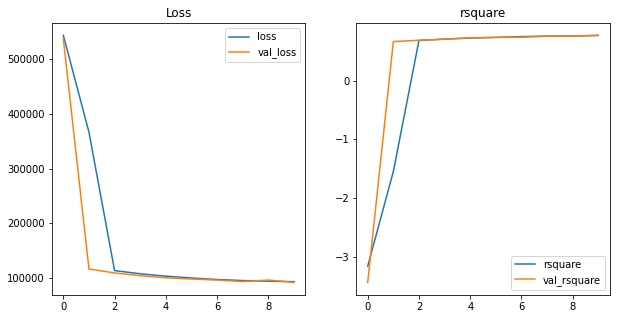

final loss: 93258.1796875
final val_loss: 91828.1875
final rsquare: 0.7696373462677002
final val_rsquare: 0.7674041986465454


In [ ]:
model = make_model()
history = model.fit(X_train,
                   y_train,
                   validation_split = .2,
                   epochs=10,
                   verbose=1)

plot_history(history)

### b. Activation functions


<img src='https://github.com/learn-co-students/011121-pt-ds/raw/main/phase_4/resources/activation.png' width=500/>

#### Activation functions for output layers (for supervised learning problems)

1. For binary classification problems: sigmoid activation to coerce values between 0-1
2. For multiclass classification: softmax activation, as it produces a non-negative vector that sums to 1 (probabilities of your test point belonging to the different classes)
3. For regression problems: linear, or relu activation (it is linear and unbounded!)

#### Activation functions for hidden layers

* TDS articles [1](https://towardsdatascience.com/exploring-activation-functions-for-neural-networks-73498da59b02) [2](https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0)
* Sigmoids are not used often because it has a small maximum derivative value and thus propagates only a small amount of error each time, leading to slow "learning" 
* This small-derivative-slow-learning issue is known as a **vanishing gradient** problem
* Tanh is mathematically quite similar to a sigmoid function, thus also has the vanishing gradient issue, but not as bad
* ReLu generally works well because its gradient is always 1 as long as the input is positive (no vanishing gradients), and negative inputs going to 0 can make your network lighter (no weights/biases are being updated)


In [ ]:
def make_model2():
    model = Sequential(name='activations')
    model.add(Dense(10, input_shape=(X_train.shape[1],), name='Dense1',
                   activation = 'relu'))
    model.add(Dense(1, activation = 'relu', name='Output'))

    model.compile(optimizer='sgd', loss='mae', metrics=[rsquare])

    display(model.summary())
    return model

Model: "activations"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 10)                880       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 891
Trainable params: 891
Non-trainable params: 0
_________________________________________________________________


None

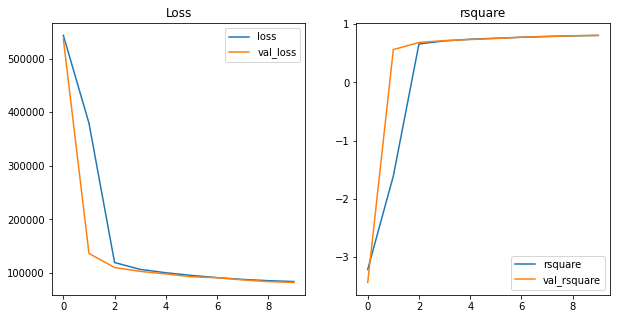

final loss: 84283.53125
final val_loss: 82582.125
final rsquare: 0.806948721408844
final val_rsquare: 0.8082377314567566


In [ ]:
model = make_model2()

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=10,
                    verbose=0)

plot_history(history)

### c. Loss functions

* Loss functions are akin to cost functions we were trying to minimize in gradient descent (i.e. RMSE for linear regression, Gini/entropy for trees)

1. For regression problems, keras has **mean_squared_error** or **mean_absolute_error** as a loss function, or **mean_squared_logarithmic_error** if your target has potential outliers
2. For binary classification, **binary_crossentropy** 
3. For multiclass problems, **categorical_crossentropy**

[This article summarizes the above, and more.](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

### d. Optimizers

* Helpful summary articles [1](https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/) [2](https://towardsdatascience.com/a-quick-guide-to-neural-network-optimizers-with-applications-in-keras-e4635dd1cca4)

* Different optimizers are just different methods/paths that your neural network can take to find optimal values
* Experimentally, Adam (derived from *adaptive moment estimation*) is a good one to use
* [More about Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)

#### Quick optimizer summary

* **RMSProp**: maintains per-parameter learning rates adapted based on the average of recent weight updates (e.g. how quickly it is changing). This does well on non-stationary problems (e.g. noisy data).  

This is also called 'Momentum'.

* **Adagrad**: maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems)

* **Adam**: realizes the benefits of both AdaGrad and RMSProp. Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance)

Model: "optimizers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 10)                880       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 891
Trainable params: 891
Non-trainable params: 0
_________________________________________________________________


None

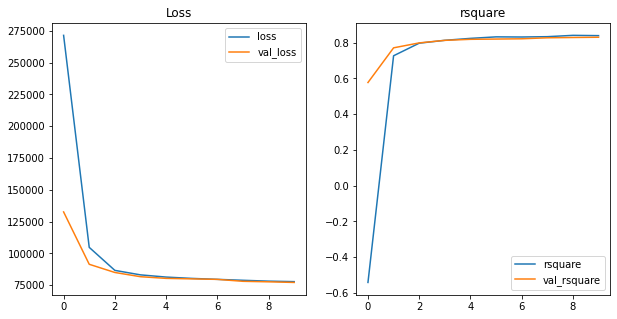

final loss: 77861.5859375
final val_loss: 77230.3515625
final rsquare: 0.8388120532035828
final val_rsquare: 0.8298704624176025


In [ ]:
def make_model3():
    model = Sequential(name='optimizers')
    model.add(Dense(10, input_shape=(X_train.shape[1],),
                   activation = 'relu', name='Dense1'))
    model.add(Dense(1, activation = 'relu', name='Output'))

    optimizer = Adam(learning_rate=0.5)
    
    model.compile(optimizer=optimizer, loss='mae', metrics=[rsquare])

    display(model.summary())
    return model

model = make_model3()

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=10,
                    verbose=0)

plot_history(history)

### e. Learning rate

* The learning rate is something you can define when you compile your model with the optimizer
* Optimizers usually change up the learning rates, so this is just the *initial* learning rate
* If you set it too low, training will eventually converge, but it will do so slowly
* If you set it too high, it might actually diverge
* If you set it slightly too high, it will converge at first but miss the local optima

Model: "overfitting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 200)               17600     
_________________________________________________________________
Dense2 (Dense)               (None, 200)               40200     
_________________________________________________________________
Dense3 (Dense)               (None, 200)               40200     
_________________________________________________________________
Dense4 (Dense)               (None, 200)               40200     
_________________________________________________________________
Dense5 (Dense)               (None, 200)               40200     
_________________________________________________________________
Output (Dense)               (None, 1)                 201       
Total params: 178,601
Trainable params: 178,601
Non-trainable params: 0
_________________________________________________

None

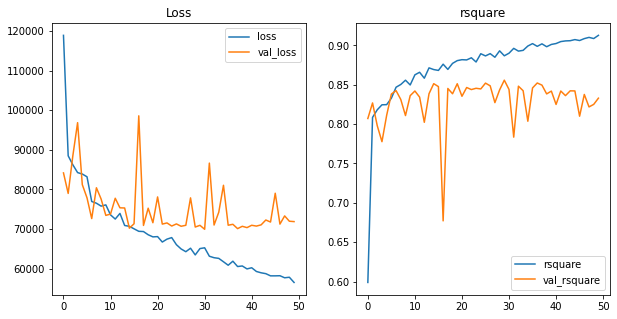

final loss: 56510.18359375
final val_loss: 71871.859375
final rsquare: 0.9126328229904175
final val_rsquare: 0.8328729271888733


In [ ]:
def make_model4():
    model = Sequential(name='overfitting')
    model.add(Dense(200, input_shape=(X_train.shape[1],),
                   activation = 'relu', name='Dense1', bia))
    model.add(Dense(200, activation = 'relu', name='Dense2'))
    model.add(Dense(200, activation = 'relu', name='Dense3'))
    model.add(Dense(200, activation = 'relu', name='Dense4'))   
    model.add(Dense(200, activation = 'relu', name='Dense5'))   

    model.add(Dense(1, activation = 'relu', name='Output'))
    optimizer = Adam(learning_rate=.01)
    model.compile(optimizer=optimizer, loss='mae', metrics=[rsquare])

    display(model.summary())
    return model

model = make_model4()

history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs=50,
                    verbose=0)

plot_history(history)

### f. Regularization

* As a neural network learns, neuron weights settle into their context within the network
* Weights of neurons are tuned for specific features providing some specialization
* Neighboring neurons become too reliant on this specialization, which if taken too far can result in a fragile model too specialized to the training data
* This reliance on context for a neuron during training is referred to as *complex co-adaptations*

#### Methods
1. You can add L1 or L2 regularization within each hidden layer
2. You can also add a **dropout layer** 
3. Not technically *regularization*, but you can introduce **early stopping** so your model doesn't overtrain

#### Dropout
Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. You can add **dropout layers** in your neural network.

<img src='https://github.com/learn-co-students/011121-pt-ds/raw/main/phase_4/resources/thanos.png'/>

Model: "regularizers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 200)               17600     
_________________________________________________________________
Dropout1 (Dropout)           (None, 200)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 200)               40200     
_________________________________________________________________
Dropout2 (Dropout)           (None, 200)               0         
_________________________________________________________________
Dense3 (Dense)               (None, 200)               40200     
_________________________________________________________________
Dropout3 (Dropout)           (None, 200)               0         
_________________________________________________________________
Dense4 (Dense)               (None, 200)              

None

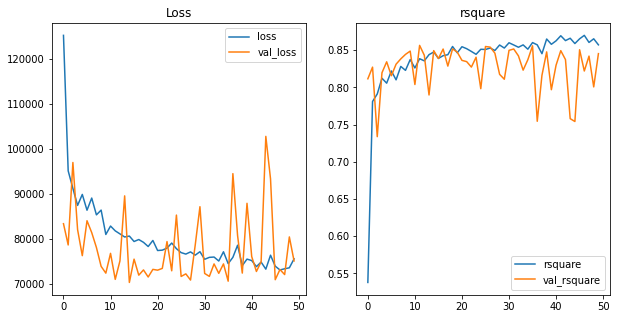

final loss: 75566.0625
final val_loss: 75101.3203125
final rsquare: 0.8572735786437988
final val_rsquare: 0.845452606678009


In [ ]:
def make_model5():
    model = Sequential(name='regularizers')
    model.add(Dense(200, input_shape=(X_train.shape[1],),
                   activation = 'relu', name='Dense1'))
    model.add(Dropout(rate=0.05, name='Dropout1'))
    model.add(Dense(200, activation = 'relu', name="Dense2"))
    model.add(Dropout(rate=0.05, name='Dropout2'))
    model.add(Dense(200, activation = 'relu', name='Dense3'))
    model.add(Dropout(rate=0.05, name='Dropout3'))
    model.add(Dense(200, activation = 'relu', name='Dense4'))
    model.add(Dropout(rate=0.05, name='Dropout4'))
    model.add(Dense(200, activation = 'relu', name='Dense5'))
    model.add(Dropout(rate=0.05, name='Dropout5'))
    model.add(Dense(1, activation = 'relu', name='Output'))

    optimizer = Adam(learning_rate=.01)
    
    model.compile(optimizer=optimizer, loss='mae', metrics=[rsquare])

    display(model.summary())
    return model

model = make_model5()


history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs = 50,
                    verbose = 0)

plot_history(history)

Model: "regularizers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 200)               17600     
_________________________________________________________________
Dropout1 (Dropout)           (None, 200)               0         
_________________________________________________________________
Dense2 (Dense)               (None, 200)               40200     
_________________________________________________________________
Dropout2 (Dropout)           (None, 200)               0         
_________________________________________________________________
Dense3 (Dense)               (None, 200)               40200     
_________________________________________________________________
Dropout3 (Dropout)           (None, 200)               0         
_________________________________________________________________
Dense4 (Dense)               (None, 200)              

None

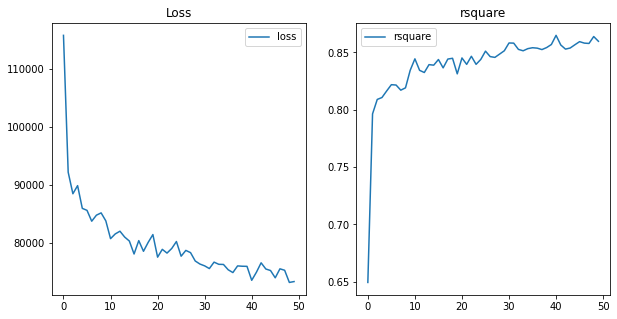

final loss: 73295.203125
final rsquare: 0.8596270680427551
final Mean Absolute Error on holdout set:  69805.36060329861
final R-Squared score on holdout set:  0.8821091661182869


In [ ]:
model = make_model5()

history = model.fit(X_train, y_train, epochs=50, verbose=0)

plot_history(history)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('final Mean Absolute Error on holdout set: ', mae)
print('final R-Squared score on holdout set: ', r2)

We can predict housing prices with the above mean absolute error.  It's okay, but not great.

# Next Steps

1. Implement Early Stopping and/or Model Checkpoint callbacks to prevent overtraining
2. Implement Reduce Learning Rate on Plateau to reduce learning rate when learning plateaus
3. Use Talos to tune hyperparameters algorithmically